In [1]:
import folium
from folium import Map, Marker, FeatureGroup, LayerControl

from openrouteservice import client, geocode, directions, places

from pprint import pprint
from shapely.geometry import Polygon, MultiPolygon, shape, mapping, LineString, Point
from shapely import wkt

import numpy as np
from matplotlib import pylab

In [2]:
def style_function(color):
    return lambda feature: dict(color=color)

# Bike route

We are a company for bike tours and our next trip will be from Dortmund to Bad Münstereifel in the beautiful Eifel. To get an idea how the trip is going to be we would like to analyse the route.

In [3]:
# Directions from Dortmund to Bad Münstereifel (Eifel)
api_key = '58d904a497c67e00015b45fc2a6b6872037d44119582ef40cdf264c4' # Provide your personal API key
clnt = client.Client(key=api_key) # Create client with api key

Dortmund = [7.46307760, 51.51194839]
Eifel = [6.763458, 50.563177]

cleaned_map = folium.Map(tiles='Stamen Toner', location=([51.086273, 7.165833]), zoom_start=9)
direct_params = {'coordinates': [Dortmund, Eifel],
                'profile': 'cycling-tour', # profile cycling-tour
                'format_out': 'geojson',
                'geometry': 'true',
                'instructions': 'false',
                 'elevation': 'true',
                 #'attributes': 'avgspeed'
                                   }
direct_request = clnt.directions(**direct_params)
folium.GeoJson(direct_request).add_to(cleaned_map)

folium.Marker(list(reversed(Dortmund)), popup='Start - Dortmund').add_to(cleaned_map)
folium.Marker(list(reversed(Eifel)), popup='Destination - Eifel').add_to(cleaned_map)
cleaned_map

Let's have a first look at general information:

In [4]:
for info in direct_request['features'][0]['properties']['summary']:
    print('Distance: {:.2f} km \nDuration: {:.2f} hours'.format(info['distance']/1000, info['duration']/3600))
    print('Total elevation difference from start to destination: {:.2f} m.'.format(info['ascent']-info['descent']))

Distance: 143.81 km 
Duration: 9.27 hours
Total elevation difference from start to destination: 174.90 m.


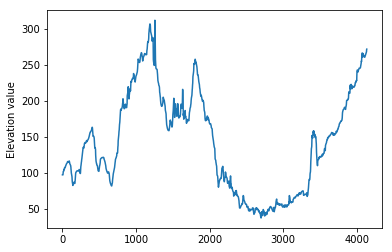

Elevation values:
  Lowest: 37.025
  Median: 137.699
  Highest: 312.092


In [5]:
elev_values = []
for elev_value in direct_request['features'][0]['geometry']['coordinates']:
    coords = [elev_value[0],elev_value[1]]
    elev_values.append(elev_value[2])

for value in direct_request['features']:
    distance = value['properties']['summary'][0]['distance']/1000

pylab.plot(elev_values)
pylab.xlabel('')
pylab.ylabel('Elevation value')
pylab.show()

print('Elevation values:\n  Lowest: {:.3f}\n  Median: {:.3f}\n  Highest: {:.3f}'.format(np.min(elev_values), np.median(elev_values), np.max(elev_values)))

In [6]:
elev_array = np.array([elev_values])

for elev_value in direct_request['features'][0]['geometry']['coordinates']:
    if elev_value[2] == np.max(elev_array):
        peak_coords = [elev_value[1], elev_value[0]]
        folium.Marker(peak_coords, 
                      icon = folium.Icon(color='green'), 
                      popup = 'Highest elevation point').add_to(cleaned_map)
        
print('The highest peak is at {} meter above zero with the coordinates {}.'.format(np.max(elev_array),peak_coords))

The highest peak is at 312.091667 meter above zero with the coordinates [51.30836, 7.240676].


Let's get an overview of our route by the extra information parameter. We get information about the steepness, the suitability, the surface and the way category.
Further information about the response values: [**OpenRouteService - Documentation**](https://github.com/GIScience/openrouteservice-docs#routing-response)

In [7]:
# Delete elevation value for a better handeling
del direct_params['elevation'] 
direct_request_noe = clnt.directions(**direct_params)

# Request extra information
direct_params['extra_info'] = {'steepness','traildifficulty', 'suitability', 'surface', 'waycategory'}
del direct_params['format_out'] # Delete 'format_out' parameter for receiving extra information
direct_extra_request = clnt.directions(**direct_params)

We will have a closer look at the steepness values. Is the route very steep? And if yes, which parts?

In [8]:
print('Steepness summary: \nNegative values indicate decline, positive incline.\n ')
for value in direct_extra_request['routes'][0]['extras']['steepness']['summary']:
    if value['amount'] > 50:
        print('{:.2f}% of the road has a value of {}.'.format(value['amount'], value['value']))

Steepness summary: 
Negative values indicate decline, positive incline.
 
69.69% of the road has a value of 0.


In [19]:
ascent = []
descent = []
flat = []
for value in direct_extra_request['routes']:
    steepness_values = value['extras']['steepness']['values']
    
    route_kombi = [steepness_values, direct_request_noe]
    
    for value in route_kombi[0]:
        if value[2] == 0:
            flat.append(value[0:2])
        if value[2] > 0:
            ascent.append(value[0:2])
        if value[2] < 0:
            descent.append(value[0:2])
   #steepness_values = [flat, ascent, descent]

    #for value in steepness_values:
 #   for i,j in value:
  #      coords = [coords['geometry']['coordinates'][i:j] for coords in route_kombi[1]['features']]
   #     folium.PolyLine([(y,x) for x,y in coords[0]], color='#cc0000').add_to(cleaned_map) # 

    for i,j in flat:
        coords = [coords['geometry']['coordinates'][i:j] for coords in route_kombi[1]['features']]
        folium.PolyLine([(y,x) for x,y in coords[0]], color='green').add_to(cleaned_map) 
    for i,j in ascent:
        coords = [coords['geometry']['coordinates'][i:j] for coords in route_kombi[1]['features']]
        folium.PolyLine([(y,x) for x,y in coords[0]], color='red').add_to(cleaned_map)
    for i,j in descent:
        coords = [coords['geometry']['coordinates'][i:j] for coords in route_kombi[1]['features']]
        folium.PolyLine([(y,x) for x,y in coords[0]], color='blue').add_to(cleaned_map)

cleaned_map


Okay, it seems like most of the way is flat. Almost 70% to be correct. It looks like the journey won't be too exhausting. Nice for beginners. 

In [50]:
# Surface
print('Surface summary:')
for value in direct_extra_request['routes'][0]['extras']['surface']['summary']:
    if value['amount'] > 50:
        #print(value) # 3 = asphalt 
        print('{:.2f}% of the route has an asphalt surface.\n'.format(value['amount']))

###
#print('Trail difficulty summary:')
#for value in direct_extra_request['routes'][0]['extras']['traildifficulty']['summary']:
 #   if value['amount'] > 50:
  #      print(value) # 
        #print('{:.2f}%')

# Suitability
print('Suitability summary: \nSuitability is ranked from 1 to 10, whereas 10 represents the best suitability.')
for value in direct_extra_request['routes'][0]['extras']['suitability']['summary']:
    if value['amount'] > 50:
        #print(value) # 10 = best suitability
        print('{:.2f}% of the route has a {} ranged suitabilty.\n'.format(value['amount'], value['value']))

# Way Category
print('Way Category summary:')
for value in direct_extra_request['routes'][0]['extras']['waycategory']['summary']:
    if value['amount'] > 50:
        print('{:.2f}% of the road is paved.'.format(value['amount']))

Surface summary:
80.06% of the route has an asphalt surface.

Suitability summary: 
Suitability is ranked from 1 to 10, whereas 10 represents the best suitability.
77.03% of the route has a 10 ranged suitabilty.

Way Category summary:
51.01% of the road is paved.


In [21]:
###
# Isochrone
iso_sight_params = {'locations': list(reversed(peak_coords)),
                    'profile': 'cycling-tour',
                    'range_type': 'distance',
                    'segments': 3000 # 
                   }
iso_sight_request = clnt.isochrones(**iso_sight_params)
folium.GeoJson(iso_sight_request).add_to(cleaned_map)

#POI
poi_sight_params = {'request': 'pois',
             'geojson': iso_sight_request['features'][0]['geometry'],
             'filter_category_ids': [335]} # 240 monument, 237 memorial, 335, 625 picnic, 627 viewpoint
poi_sight_request = clnt.places(**poi_sight_params)
poi_coords = []
for hotel in poi_sight_request['features']:
    name = hotel['properties']['osm_tags']['name']
    poi_coord = hotel['geometry']['coordinates']
    folium.map.Marker(list(reversed(hotel['geometry']['coordinates'])),
                     icon=folium.Icon(color='white',
                                            icon_color='red',
                                            icon='sort-up',
                                            prefix='fa'
                                           ), popup=name).add_to(cleaned_map)
    poi_coords.append(poi_coord)

#cleaned_map

In [22]:
# create buffer around route -> search for pois 
line_tup = []
for line in direct_request_noe['features'][0]['geometry']['coordinates']:
    tup_format = tuple(line)
    line_tup.append(tup_format)  

new_linestring = LineString(line_tup)
dilated_route = new_linestring.buffer(0.015)

poly = Polygon(dilated_route)
aoi_coords = list(poly.exterior.coords)
folium.features.PolygonMarker([(y,x) for x,y in aoi_coords]).add_to(cleaned_map)
cleaned_map

## Geocoding

In [23]:
# Geocoding 
poi_dict = {'Kölner Dom'}

point_geom = []
address_request = geocode.pelias_search(client=clnt, text=poi_dict)
for l in address_request['features']:
    point = l['geometry']['coordinates']
    name = l['properties']['name']
    if name == 'Kölner Dom':
        poi_tup = tuple(point)
        point = Point(poi_tup)
        point_geom.append(point)

        # clean point list -> which one is within to the route buffer
        if point.within(dilated_route): 
            point_coords = list(point.coords) # get point coordinates
            for x,y in point_coords:
                switched = [y,x]
                folium.Marker(switched, popup=name).add_to(cleaned_map)
cleaned_map

In [60]:
from shapely.geometry import Point
# Create geometry of construction points 
point_geom = []
for point in poi_coords:
    poi_tup = tuple(point)
    poi_geom = Point(poi_tup)
    point_geom.append(poi_geom)
    
# Request route with avoiding construction points which are located on route    
for point in point_geom:
    if point.within(dilated_route): 
        point_coords = list(point.coords) # get point coordinates
        print(point_coords)

[(7.23065209999997, 51.31524010000003)]


Furthermore, it would be nice to get some information about available monuments and sight seeing points along the way. 

In [ ]:
listed_coord = []
for coord in aoi_coords:
    listed_coord += [[round(coord[0],6), round(coord[1],6)]]


json_coords = {
      "type": "FeatureCollection",
      "features": [{
          "type": "Feature",
          "properties": {},
          "geometry": {
            "type": "Polygon",
            "coordinates": [listed_coord]
          }}]}

In [72]:
import json
geo_str = json.dumps(json_coords['features'][0])
json_geo = json.loads(geo_str)

In [ ]:
poi_params = {'request': 'pois',
             'geojson': json_geo,
             'filter_category_ids': [240]} # monument
poi_request = clnt.places(**poi_params)